In [75]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import climtas
import map_trend_functions as mapTrend
import dask.distributed
import tempfile

In [76]:
tmpdir = tempfile.TemporaryDirectory('dask-worker-space')
dask.distributed.Client(local_directory=tmpdir.name, memory_limit='16gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36175/status,
Dashboard: http://127.0.0.1:36175/status,Workers: 4
Total threads: 16,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38521,Workers: 4
Dashboard: http://127.0.0.1:36175/status,Total threads: 16
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:45019,Total threads: 4
Dashboard: http://127.0.0.1:40439/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:46269,


In [77]:
sys.path.append('../functions/')
# import trend_functions_2 as tf2
# Collection of statistics
import mystats
import load_dataset as load
from importlib import reload
import phase_calc_functions as phase_calc

import phase_plot_functions as phase_plot

import subphase_calc_functions as subphase_calc

from miscellaneous import apply_masks
image_dir = '/g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/'

In [78]:
reload(load)
# olr_da =  load.load_olr_da_regridded().compute()
olr_da = load.load_olr_da().compute()

In [79]:
olr_da

<xarray.DataArray 'mtnlwrf' (time: 15796, lat: 61, lon: 181)>
array([[[-237.92368, -224.84009, -217.67297, ..., -176.63472,
         -182.38655, -187.61148],
        [-241.31058, -227.98366, -221.48203, ..., -187.22295,
         -190.49446, -193.93092],
        [-243.69958, -228.86047, -222.98386, ..., -201.87106,
         -200.9491 , -201.04633],
        ...,
        [-291.49353, -290.9231 , -290.4069 , ..., -295.81345,
         -295.4669 , -295.25555],
        [-292.3657 , -291.80057, -291.22165, ..., -294.7873 ,
         -294.38434, -294.09238],
        [-293.2952 , -292.8361 , -292.25845, ..., -294.3398 ,
         -293.9318 , -293.62885]],

       [[-262.10507, -260.37973, -260.14407, ..., -205.78174,
         -208.19994, -207.80652],
        [-265.1408 , -263.66736, -263.01254, ..., -207.48174,
         -210.86778, -213.86438],
        [-267.8631 , -266.69308, -265.49243, ..., -209.53252,
         -213.6227 , -218.28093],
...
        [-263.84015, -266.014  , -266.29944, ..., -284.56723,
         -284.68207, -284.49274],
        [-256.36368, -258.6179 , -261.44116, ..., -282.74387,
         -282.67703, -282.38983],
        [-246.59431, -250.13692, -252.95213, ..., -279.50717,
         -279.21326, -278.98483]],

       [[-257.6121 , -258.07632, -259.48743, ..., -280.55054,
         -279.93585, -278.8918 ],
        [-258.90286, -258.9675 , -260.60263, ..., -281.20523,
         -280.52347, -279.68997],
        [-259.82065, -260.36526, -262.20566, ..., -281.4349 ,
         -280.60406, -280.26187],
        ...,
        [-268.9314 , -253.96863, -240.89601, ..., -279.68362,
         -279.7511 , -279.75482],
        [-269.83304, -254.8908 , -240.34486, ..., -279.65982,
         -279.80527, -279.66003],
        [-269.83304, -254.85474, -240.3383 , ..., -279.54932,
         -279.73624, -279.60764]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-31
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0

In [80]:
# Convert from negative to positive due to direction change.
olr_da = -1 * olr_da

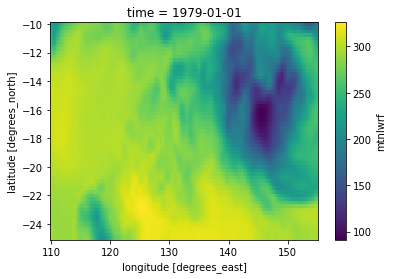

In [81]:
olr_da.isel(time=0).plot()

In [82]:
def dask_percentile(array: np.ndarray, axis: str, q: float):
    array = array.rechunk({axis: -1})
    return array.map_blocks(
        np.percentile,
        axis=axis,
        q=q,
        dtype=array.dtype,
        drop_axis=axis)

In [83]:
olr_p75_threshold = olr_da.reduce(np.nanpercentile,dim='time',  q=75)
olr_p75_threshold

<xarray.DataArray 'mtnlwrf' (lat: 61, lon: 181)>
array([[293.59033966, 293.68255615, 293.7816925 , ..., 275.04832458,
        274.94158173, 274.7489624 ],
       [294.22490692, 294.33604431, 294.37378693, ..., 276.51337433,
        276.33851624, 276.11616516],
       [294.7840271 , 294.8500824 , 294.95639038, ..., 277.79186249,
        277.63232422, 277.41079712],
       ...,
       [294.43444061, 294.82081604, 295.2614212 , ..., 289.80251312,
        289.54184723, 289.3133316 ],
       [294.13709259, 294.45637512, 294.89407349, ..., 289.47652435,
        289.2144928 , 289.07434845],
       [293.69055176, 294.08886719, 294.47750092, ..., 289.15396118,
        288.90697479, 288.71322632]])
Coordinates:
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0

In [84]:
olr_p75_da = olr_da.where(olr_da > olr_p75_threshold)
olr_p75_da

<xarray.DataArray 'mtnlwrf' (time: 15796, lat: 61, lon: 181)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 295.81345, 295.4669 ,
         295.25555],
        [      nan,       nan,       nan, ..., 294.7873 , 294.38434,
         294.09238],
        [      nan,       nan,       nan, ..., 294.3398 , 293.9318 ,
         293.62885]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 280.55054, 279.93585,
         278.8918 ],
        [      nan,       nan,       nan, ..., 281.20523, 280.52347,
         279.68997],
        [      nan,       nan,       nan, ..., 281.4349 , 280.60406,
         280.26187],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-31
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0

In [85]:
# Loading RMM
rmm = load.load_rmm()

In [86]:
rmm

<xarray.Dataset>
Dimensions:    (time: 17592)
Coordinates:
  * time       (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2022-07-30
Data variables:
    RMM1       (time) float64 1.634 1.603 1.516 1.51 ... -0.0587 0.1307 0.2057
    RMM2       (time) float64 1.203 1.015 1.086 ... -0.8601 -0.5946 -0.5724
    phase      (time) int64 5 5 5 5 5 6 6 6 6 7 6 5 ... 7 8 8 1 1 1 1 1 2 2 3 3
    amplitude  (time) float64 2.029 1.897 1.865 1.831 ... 0.8621 0.6088 0.6082

In [87]:
# Making sure the two are the same length
olr_p75_da = olr_p75_da.where(olr_p75_da.time.isin(rmm.time.values), drop = True)
rmm = rmm.where(rmm.time.isin(olr_p75_da.time.values), drop = True)
print('olr_da length: {}      RMM length: {} '.format(len(olr_p75_da.time.values), len(rmm.time.values)))

olr_da length: 15796      RMM length: 15796 


In [88]:
olr_p75_da

<xarray.DataArray 'mtnlwrf' (time: 15796, lat: 61, lon: 181)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 295.81345, 295.4669 ,
         295.25555],
        [      nan,       nan,       nan, ..., 294.7873 , 294.38434,
         294.09238],
        [      nan,       nan,       nan, ..., 294.3398 , 293.9318 ,
         293.62885]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 280.55054, 279.93585,
         278.8918 ],
        [      nan,       nan,       nan, ..., 281.20523, 280.52347,
         279.68997],
        [      nan,       nan,       nan, ..., 281.4349 , 280.60406,
         280.26187],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-31
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0

In [89]:
phase_calc = reload(phase_calc)
olr_ws = phase_calc.wet_season_year(olr_p75_da)

rmm_ws = phase_calc.wet_season_year(rmm)

# Splitting olr into the the different phases of the Wheeler and Hendon MJO
olr_split_ws = phase_calc.split_into_1to8(olr_ws, rmm_ws)

In [90]:
olr_split_ws

<xarray.DataArray 'mtnlwrf' (phase: 9, time: 5304, lat: 61, lon: 181)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'

In [91]:
def count_resample(ds_data):
    name = ds_data.name
    ds_data = ds_data.to_dataset()
    # countring the rainfall events in each Wheeler and Hendon Phase
    ds_count = ds_data.resample(time = 'y').count(dim = 'time')
    ds_count['time'] = ds_count.time.dt.year
    ds_count = ds_count.rename({'time':'year', name:'number'}) # to match the rmm count
    return ds_count

In [92]:
olr_split_ws.name = 'mtnlwrf'

In [93]:
# The number of raindays each wet season.
olr_count = count_resample(olr_split_ws)

In [94]:
olr_count_sub = phase_calc.resample_phase_to_subphase(olr_count)
olr_count_sub

<xarray.Dataset>
Dimensions:  (year: 44, lon: 181, lat: 61, phase: 4)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2018 2019 2020 2021 2022
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year, lat, lon) int64 0 0 0 0 0 0 0 0 0 ... 9 9 8 7 7 7 7 8

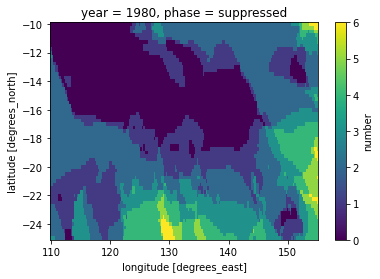

In [95]:
olr_count_sub.sel(year=1980, phase='suppressed').number.plot()

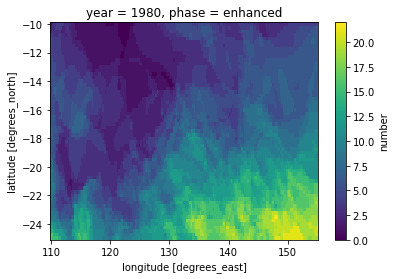

In [96]:
olr_count_sub.sel(year=1980, phase='enhanced').number.plot()

In [97]:
# This is the raw trend, the data has not been normalised
phase_calc = reload(phase_calc)
trend_count_sub, trend_sig_count_sub, trend_percent_count_sub, trend_percent_sig_count_sub = \
    phase_calc.return_alltrendinfo_custom(olr_count_sub.number)

data
<xarray.DataArray 'number' (phase: 4, year: 44, lat: 61, lon: 181)>
array([[[[ 0,  0,  0, ...,  5,  5,  5],
         [ 0,  0,  0, ...,  5,  5,  5],
         [ 0,  0,  0, ...,  5,  5,  5],
         ...,
         [12, 10, 11, ...,  5,  5,  4],
         [12, 11, 11, ...,  5,  5,  5],
         [12, 12, 12, ...,  6,  6,  7]],

        [[ 1,  3,  3, ...,  4,  4,  5],
         [ 2,  3,  3, ...,  6,  6,  6],
         [ 2,  3,  3, ...,  6,  6,  6],
         ...,
         [14, 14, 13, ..., 20, 20, 20],
         [16, 16, 14, ..., 19, 20, 20],
         [16, 15, 15, ..., 19, 19, 19]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
...
         ...,
         [21, 21, 21, ..., 25, 26, 26],
         [24, 22, 21, ..., 26, 26, 27],
         [25, 24, 23, ..., 25, 27, 26]],

        [[ 1,  1,  1, ...,  5,  6,  6],
         [ 1,  1,  1, ...,  4,  5,  5],
         [ 2,  2,  2, ...,  4,  4,  5],
         ...,
       

In [98]:
trend_count_sub

<xarray.DataArray 'number' (phase: 4, lat: 61, lon: 181)>
array([[[ 0.02219873,  0.01508104,  0.01268499, ...,  0.0243129 ,
          0.02198732,  0.03058492],
        [ 0.01557435,  0.01486963,  0.0136716 , ...,  0.00352361,
          0.00972516,  0.0187456 ],
        [ 0.01353066,  0.0055673 ,  0.00768147, ...,  0.00317125,
          0.00979563,  0.0098661 ],
        ...,
        [ 0.16568006,  0.17885835,  0.19027484, ...,  0.0620155 ,
          0.07040169,  0.07258633],
        [ 0.17420719,  0.16039464,  0.17921071, ...,  0.06116984,
          0.06645525,  0.07159972],
        [ 0.17730796,  0.1653277 ,  0.16081748, ...,  0.05525018,
          0.05151515,  0.05384073]],

       [[-0.04700493, -0.03812544, -0.0354475 , ..., -0.11966173,
         -0.12241015, -0.12565187],
        [-0.03312192, -0.0354475 , -0.0415081 , ..., -0.13255814,
         -0.11937984, -0.12522903],
        [-0.03107822, -0.04369274, -0.03868922, ..., -0.12093023,
         -0.10852713, -0.11726568],
...
        [ 0.05137421,  0.07237491,  0.08280479, ...,  0.00894996,
          0.0093728 ,  0.01740662],
        [ 0.08047921,  0.07343199,  0.07815363, ...,  0.02276251,
          0.00944327,  0.00662438],
        [ 0.07998591,  0.07801268,  0.07561663, ...,  0.03093728,
          0.02797745,  0.02727273]],

       [[-0.04693446, -0.04214235, -0.0465821 , ..., -0.01853418,
         -0.03396758, -0.03854827],
        [-0.05003524, -0.05151515, -0.05052854, ..., -0.03312192,
         -0.03051445, -0.02374912],
        [-0.04594785, -0.04933051, -0.04918957, ..., -0.01550388,
         -0.01522199, -0.02670895],
        ...,
        [-0.1278365 , -0.14489077, -0.14312896, ..., -0.14341085,
         -0.13234672, -0.13495419],
        [-0.10584919, -0.12776603, -0.13269908, ..., -0.14193094,
         -0.13136011, -0.12776603],
        [-0.12755462, -0.11719521, -0.12424242, ..., -0.14756871,
         -0.12403101, -0.12656801]]])
Coordinates:
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'

In [99]:
trend_percent_count_sub = trend_percent_count_sub.compute()

In [100]:
trend_percent_sig_count_sub = trend_percent_sig_count_sub.compute()

In [101]:
trend_percent_count_sub

<xarray.DataArray 'number' (phase: 4, lat: 61, lon: 181)>
array([[[ 33.680834  ,  22.11886305,  18.60465116, ...,   7.58700313,
           6.81297085,   9.21737284],
        [ 23.63004544,  21.10527632,  21.48394241, ...,   1.07665805,
           2.9308697 ,   5.64935754],
        [ 17.51025992,   6.99889258,  10.24195443, ...,   0.96230954,
           3.05679257,   3.01464255],
        ...,
        [ 11.85353249,  12.94369645,  13.67989056, ...,   6.20155039,
           6.9299204 ,   7.19323975],
        [ 12.20559917,  11.34624492,  12.82157938, ...,   6.06187583,
           6.5708562 ,   7.09546756],
        [ 12.11420868,  11.40191004,  11.19615347, ...,   5.42635659,
           5.07084265,   5.24113329]],

       [[-26.85996174, -21.78596597, -20.25571328, ..., -17.66817543,
         -17.89384223, -18.74129549],
        [-17.34957549, -18.79144485, -20.99260447, ..., -20.18186207,
         -17.98874376, -19.06601218],
        [-14.09733877, -20.02583979, -18.30457614, ..., -19.4194534 ,
         -17.05426357, -18.29677277],
...
        [  5.12577124,   7.22107965,   8.33732461, ...,   1.17551776,
           1.20939326,   2.21997528],
        [  7.76553788,   7.244412  ,   7.6929747 , ...,   2.95442592,
           1.18715393,   0.82804792],
        [  7.70104999,   7.54408382,   7.37723233, ...,   3.90040203,
           3.48727408,   3.28767123]],

       [[-21.96932212, -19.72620815, -22.03884304, ...,  -2.69143193,
          -4.8212053 ,  -5.48907453],
        [-20.76934328, -21.58730159, -21.17386489, ...,  -4.89048437,
          -4.46058358,  -3.49485365],
        [-17.42849505, -19.73220578, -20.04019523, ...,  -2.33620049,
          -2.26272784,  -3.90429833],
        ...,
        [ -7.2484616 ,  -8.30103359,  -8.29733125, ..., -12.20517895,
         -11.28537948, -11.35369885],
        [ -5.80718746,  -7.12510193,  -7.53388347, ..., -11.73864895,
         -10.98829841, -10.54728973],
        [ -6.98060087,  -6.42165523,  -6.94620923, ..., -12.02411714,
         -10.0689379 , -10.2371181 ]]])
Coordinates:
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'

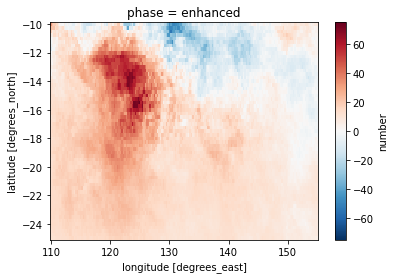

In [102]:
trend_percent_count_sub.sel(phase='enhanced').plot()

In [129]:
trend_percent_count_sub

<xarray.DataArray 'number' (phase: 4, lat: 61, lon: 181)>
array([[[ 33.680834  ,  22.11886305,  18.60465116, ...,   7.58700313,
           6.81297085,   9.21737284],
        [ 23.63004544,  21.10527632,  21.48394241, ...,   1.07665805,
           2.9308697 ,   5.64935754],
        [ 17.51025992,   6.99889258,  10.24195443, ...,   0.96230954,
           3.05679257,   3.01464255],
        ...,
        [ 11.85353249,  12.94369645,  13.67989056, ...,   6.20155039,
           6.9299204 ,   7.19323975],
        [ 12.20559917,  11.34624492,  12.82157938, ...,   6.06187583,
           6.5708562 ,   7.09546756],
        [ 12.11420868,  11.40191004,  11.19615347, ...,   5.42635659,
           5.07084265,   5.24113329]],

       [[-26.85996174, -21.78596597, -20.25571328, ..., -17.66817543,
         -17.89384223, -18.74129549],
        [-17.34957549, -18.79144485, -20.99260447, ..., -20.18186207,
         -17.98874376, -19.06601218],
        [-14.09733877, -20.02583979, -18.30457614, ..., -19.4194534 ,
         -17.05426357, -18.29677277],
...
        [  5.12577124,   7.22107965,   8.33732461, ...,   1.17551776,
           1.20939326,   2.21997528],
        [  7.76553788,   7.244412  ,   7.6929747 , ...,   2.95442592,
           1.18715393,   0.82804792],
        [  7.70104999,   7.54408382,   7.37723233, ...,   3.90040203,
           3.48727408,   3.28767123]],

       [[-21.96932212, -19.72620815, -22.03884304, ...,  -2.69143193,
          -4.8212053 ,  -5.48907453],
        [-20.76934328, -21.58730159, -21.17386489, ...,  -4.89048437,
          -4.46058358,  -3.49485365],
        [-17.42849505, -19.73220578, -20.04019523, ...,  -2.33620049,
          -2.26272784,  -3.90429833],
        ...,
        [ -7.2484616 ,  -8.30103359,  -8.29733125, ..., -12.20517895,
         -11.28537948, -11.35369885],
        [ -5.80718746,  -7.12510193,  -7.53388347, ..., -11.73864895,
         -10.98829841, -10.54728973],
        [ -6.98060087,  -6.42165523,  -6.94620923, ..., -12.02411714,
         -10.0689379 , -10.2371181 ]]])
Coordinates:
  * lon      (lon) float32 110.0 110.2 110.5 110.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -24.5 -24.75 -25.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'

In [137]:
# .sel(lat=slice(None, -23)),

Saving to /g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/06_olr_count_all_unnorm_subphase.png


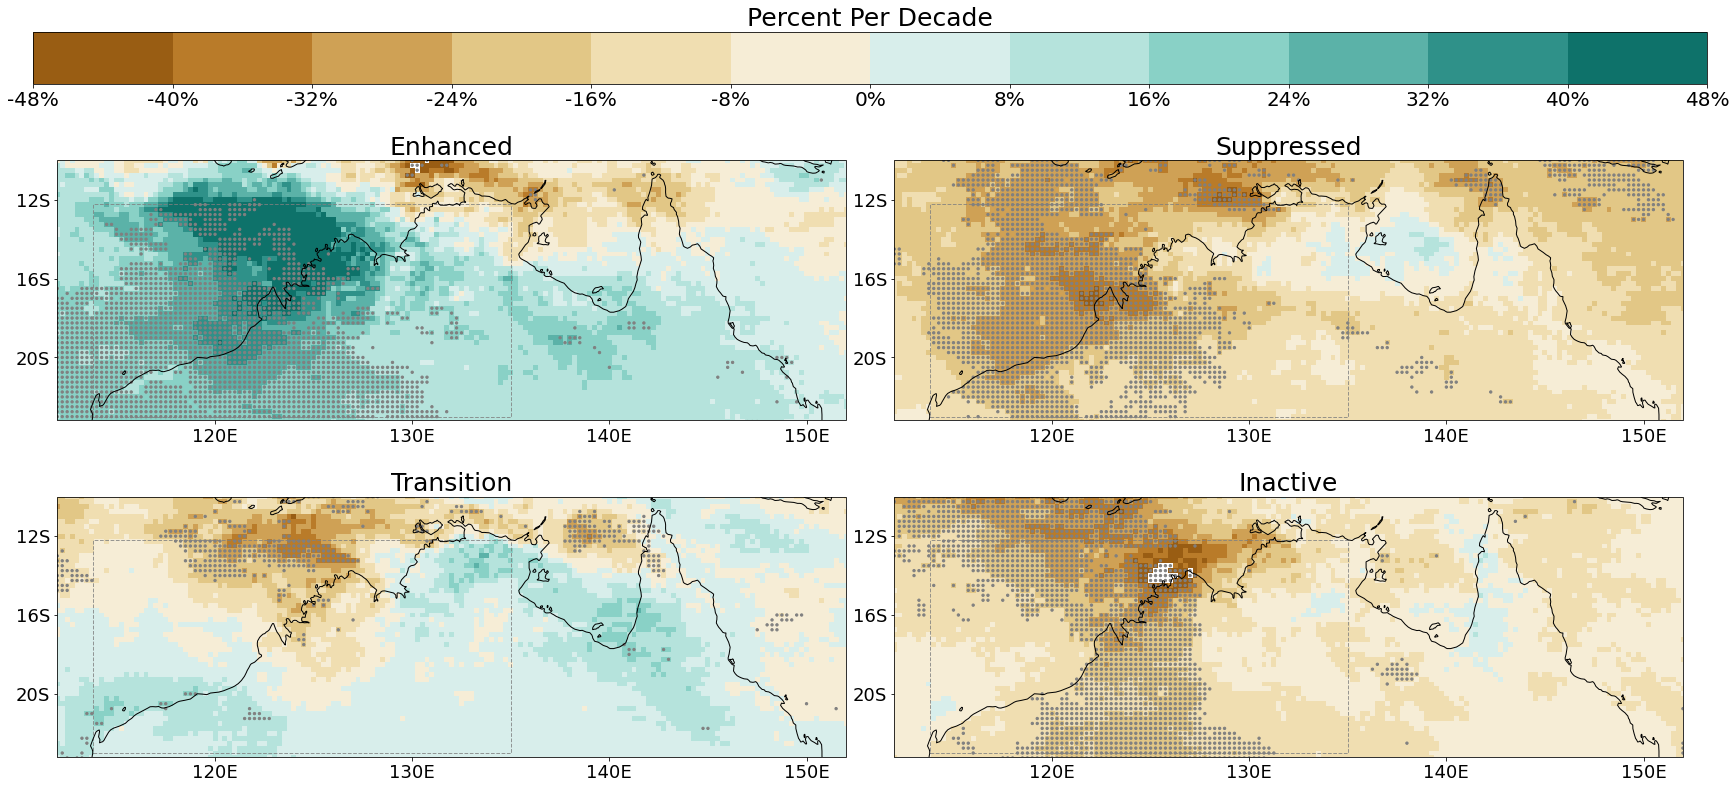

In [146]:
mapTrend = reload(mapTrend)
mapTrend.trend_plots(trend_percent_count_sub ,
                     stip_data = trend_percent_sig_count_sub,
               vmax = 48, step = 8, sig_size = 5.5, cmap = 'BrBG',
                     stiple_reduction=False, 
               title = '06_olr_count_all_unnorm_subphase', colorbar_title = 'Percent Per Decade'
               ,savedir = image_dir
               )